In [1]:
import harmonica as hm
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import skimage.exposure
import xarray as xr

import magali as mg

In [2]:
sensor_sample_distance = 5.0  # µm
region = [0, 2000, 0, 2000]  # µm
spacing = 2  # µm

true_inclination = 30
true_declination = 40
true_dispersion_angle = 5

size = 100

directions_inclination, directions_declination = mg.random_directions(
    true_inclination,
    true_declination,
    true_dispersion_angle,
    size=size,
    random_state=5,
)

dipoles_amplitude = abs(np.random.normal(0, 100, size)) * 1.0e-14

dipole_coordinates = (
    np.concatenate([np.random.randint(30, 1970, size), [1250, 1300, 500]]),  # µm
    np.concatenate([np.random.randint(30, 1970, size), [500, 1750, 1000]]),  # µm
    np.concatenate([np.random.randint(-20, -1, size), [-15, -15, -30]]),  # µm
)
dipole_moments = hm.magnetic_angles_to_vec(
    inclination=np.concatenate([directions_inclination, [10, -10, -5]]),
    declination=np.concatenate([directions_declination, [10, 170, 190]]),
    intensity=np.concatenate([dipoles_amplitude, [5e-11, 5e-11, 5e-11]]),
)

data = mg.dipole_bz_grid(
    region, spacing, sensor_sample_distance, dipole_coordinates, dipole_moments
)

data_tga = mg.total_gradient_amplitude_grid(data)
data

/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)
/home/yago/miniforge3/envs/magali/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


<xarray.DataArray 'bz' (y: 1001, x: 1001)> Size: 8MB
array([[13.21284492, 13.41642987, 13.62320443, ..., 14.39437191,
        14.10125635, 13.81577031],
       [13.43095152, 13.64071514, 13.85382453, ..., 14.66171125,
        14.35760251, 14.06163914],
       [13.65314608, 13.86926333, 14.08888743, ..., 14.9332151 ,
        14.61777777, 14.31102815],
       ...,
       [ 2.57335717,  2.59880038,  2.62466239, ...,  5.82555705,
         5.78136776,  5.73742646],
       [ 2.56122142,  2.58654654,  2.61229078, ...,  5.74612705,
         5.70312284,  5.66035046],
       [ 2.54910333,  2.57430955,  2.59993512, ...,  5.66798191,
         5.62613062,  5.58449575]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0
Attributes:
    long_name:  vertical magnetic field
    units:      nT

In [3]:
stretched = skimage.exposure.rescale_intensity(
    data_tga,
    in_range=tuple(np.percentile(data_tga, (1, 99))),
)
data_tga_stretched = xr.DataArray(stretched, coords=data_tga.coords)
data_tga_stretched

<xarray.DataArray (y: 1001, x: 1001)> Size: 8MB
array([[0.00285186, 0.00295574, 0.00302733, ..., 0.00241634, 0.00238159,
        0.00225886],
       [0.00072412, 0.00040921, 0.00049563, ..., 0.0002919 , 0.00035276,
        0.00011914],
       [0.0004379 , 0.00068751, 0.00064808, ..., 0.00057713, 0.00051546,
        0.00062927],
       ...,
       [0.00138791, 0.00031294, 0.00068003, ..., 0.00022361, 0.000572  ,
        0.00041517],
       [0.00011521, 0.0007714 , 0.00046137, ..., 0.00062942, 0.00029109,
        0.00121815],
       [0.00380614, 0.00265104, 0.00310822, ..., 0.00215231, 0.00250378,
        0.00124227]])
Coordinates:
  * x        (x) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
  * y        (y) float64 8kB 0.0 2.0 4.0 6.0 ... 1.996e+03 1.998e+03 2e+03
    z        (y, x) float64 8MB 5.0 5.0 5.0 5.0 5.0 5.0 ... 5.0 5.0 5.0 5.0 5.0

### Stretch the contrast of TGA

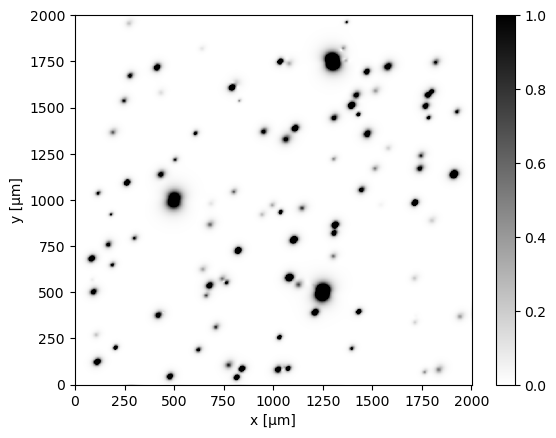

In [4]:
data_tga_stretched.plot.pcolormesh(cmap="gray_r")

## Detection

In [5]:
size_range = [25, 50]
size_increment = 1.0
threshold = 0.01
overlap = 0.3
exclude_border = 1
num_scales = 5
border_exclusion = 0
overlap_ratio = 0.3

In [9]:
windows = mg.detect_anomalies(
    data_tga_stretched,
    size_range,
    size_multiplier=2,
    num_scales=10,
    detection_threshold=0.01,
    overlap_ratio=0.5,
    border_exclusion=1,
)

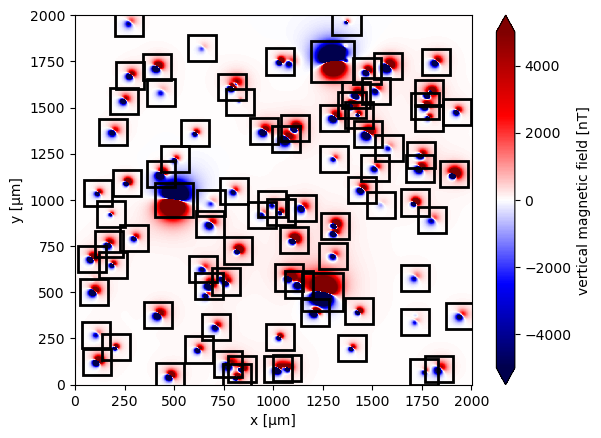

In [10]:
ax = plt.subplot(111)
data.plot.pcolormesh(ax=ax, cmap="seismic", vmin=-5000, vmax=5000)
for window in windows:
    rect = matplotlib.patches.Rectangle(
        xy=[window[0], window[2]],
        width=window[1] - window[0],
        height=window[3] - window[2],
        edgecolor="k",
        fill=False,
        linewidth=2,
    )
    ax.add_patch(rect)

# Write tests